In [1]:
import sounddevice as sd
import numpy as np
import time
from tqdm import tqdm
import threading
from scipy import signal
from random import randint
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
import random
from PyDMXControl.controllers import OpenDMXController
from PyDMXControl.profiles.Generic import Dimmer, Custom
%matplotlib inline

In [2]:
# find the Clarett and use it
for d in sd.query_devices():
    if d['name'].find('Scarlett 18i20 USB') >= 0:
        dev = d['name']
        break

SAMPLERATE = 16000
# set the blocksize to 20Hz
MINIMUM_FREQUENCY = 20
BLOCKSIZE = int(round(SAMPLERATE/MINIMUM_FREQUENCY))


dmx = OpenDMXController()
l1 = dmx.add_fixture(Custom(channels=7, start_channel=1))# make a dict of RGB colors to their DMX values
l2 = dmx.add_fixture(Custom(channels=7, start_channel=8))# make a dict of RGB colors to their DMX values
l3 = dmx.add_fixture(Custom(channels=7, start_channel=16))# make a dict of RGB colors to their DMX values
l4 = dmx.add_fixture(Custom(channels=7, start_channel=24))# make a dict of RGB colors to their DMX values
# this is the color wheel
# something nice about this is that if you want to make a color, you can just average the values of the colors you want to mix

colors = {
    'red': [255, 0, 0],
    'orange': [255, 127, 0],
    'yellow': [255, 255, 0],
    'green': [0, 255, 0],
    'blue': [0, 0, 255],
    'purple': [75, 0, 130],
    'pink': [255, 0, 255],
    'white': [255, 255, 255]
}

def hex_to_rgb(hex):
  return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

def random_color():
    """
    Returns a random color from the color wheel
    """
    return np.random.choice(list(colors.keys()))

def RGB(brightness=255, color='pink', strobe=False, strobe_speed=255):
    """
    Returns the list of 7 DMX values for the RGB light
    """
    if strobe:
        strobe_val = 255
    else:
        strobe_val = 0
    return [brightness, colors[color][0], colors[color][1], colors[color][2], strobe_val, 0, 0]

def RGB2(color, brightness):
    """
    Returns the list of 7 DMX values for the RGB light
    """
    return [brightness, color[0], color[1], color[2], 0, 0, 0]

# set them to blue
l1.set_channels(RGB(color='blue'))
l2.set_channels(RGB(color='yellow'))
l3.set_channels(RGB(color='green'))
l4.set_channels(RGB(color='purple'))


In [3]:
# pink = (170,68,131)
# yellow = (224,169,49)
# blue = (83,116,170)
# white = (250,239,237)

In [4]:
l1.set_channels(RGB(color='white'))
l2.set_channels(RGB(color='yellow'))
l3.set_channels(RGB(color='pink'))
l4.set_channels(RGB(color='blue'))

In [4]:
# function for converting an rms value to a dmx value between 20 and 230, given the range of the rms values
range2 = (1, 255)
epsilon = 0.000001
def rms_to_dmx(rms, range1, range2):
    stoc = randint(0, 1)
    # range is a tuple of the minimum and maximum rms values
    # first, normalize the rms value to between 0 and 1
    norm = (rms - range1[0])/((range1[1] - range1[0]) + epsilon)
    # then, convert that to the range of dmx values
    if rms >= range1[1:]:
        return range2[1] - stoc
    elif rms <= range1[0]:
        return range2[0] + stoc
    else:
        val = int(norm*range2[1] + range2[0]) #+ stoc
        if val > 255:
            val = range2[1] #- stoc
        elif val < 0:
            val = range2[0] #+ stoc
        else:
            val = val
        return val
    

In [5]:
#rms1s, rms2s, rms3s, rms4s = [], [], [], []
ch1_range = (0.0,0.5)
ch2_range = (0.0,0.5)
ch3_range = (0.0,0.5)
ch4_range = (0.0,0.5)

def light_sound(indata, outdata, frames, time, status=None):
    ch1, ch2, ch3, ch4 = indata[:, 0], indata[:, 1], indata[:, 2], indata[:, 3]
    # get the rms of the signal for each channel
    rms1 = np.sqrt(np.mean(ch1**2))
    rms2 = np.sqrt(np.mean(ch2**2))
    rms3 = np.sqrt(np.mean(ch3**2))
    rms4 = np.sqrt(np.mean(ch4**2))
    #rms1s.append(rms1)
    #rms2s.append(rms2)
    #rms3s.append(rms3)
    #rms4s.append(rms4)
    # convert the rms values to dmx values
    dmx1 = rms_to_dmx(rms1, ch1_range, range2)
    dmx2 = rms_to_dmx(rms2, ch2_range, range2)
    dmx3 = rms_to_dmx(rms3, ch3_range, range2)
    dmx4 = rms_to_dmx(rms4, ch4_range, range2)
    # set the light values
    l1.set_channels(RGB(brightness=dmx1, color='white'))
    l2.set_channels(RGB(brightness=dmx2, color='yellow'))
    l3.set_channels(RGB(brightness=dmx3, color='pink'))
    l4.set_channels(RGB(brightness=dmx4, color='blue'))


In [6]:
with sd.InputStream(callback=light_sound, device=dev, channels=4, samplerate=16000, blocksize=BLOCKSIZE):
    while True:
        continue

KeyboardInterrupt: 

: 

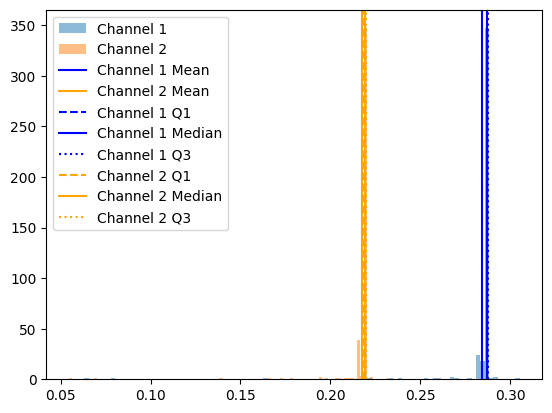

In [13]:
# plt.hist(rms1s, bins=100, alpha=0.5, label='Channel 1')
# plt.hist(rms2s, bins=100, alpha=0.5, label='Channel 2')
# # plot vertical lines for the means and each quartile for each channel, labeled
# plt.axvline(np.mean(rms1s), color='blue', label='Channel 1 Mean')
# plt.axvline(np.mean(rms2s), color='orange', label='Channel 2 Mean')
# plt.axvline(np.percentile(rms1s, 25), color='blue', linestyle='--', label='Channel 1 Q1')
# plt.axvline(np.percentile(rms1s, 50), color='blue', linestyle='-', label='Channel 1 Median')
# plt.axvline(np.percentile(rms1s, 75), color='blue', linestyle=':', label='Channel 1 Q3')
# plt.axvline(np.percentile(rms2s, 25), color='orange', linestyle='--', label='Channel 2 Q1')
# plt.axvline(np.percentile(rms2s, 50), color='orange', linestyle='-', label='Channel 2 Median')
# plt.axvline(np.percentile(rms2s, 75), color='orange', linestyle=':', label='Channel 2 Q3')
# plt.legend()

In [6]:
def random_color():
    """
    Returns a random color from the color wheel
    """
    return np.random.choice(list(colors.keys()))

In [10]:
# set both to rainbow strobe for 5 seconds
t0 = time.time()
while time.time() - t0 < 5:
    c1 = random_color()
    c2 = random_color()
    l1.set_channels(RGB(strobe=True, strobe_speed=255, color=c1))
    l2.set_channels(RGB(strobe=True, strobe_speed=255, color=c2))
    time.sleep(0.1)
l1.set_channels(RGB(color='blue'))
l2.set_channels(RGB(color='yellow'))

: 

In [9]:
# turn them off
l1.set_channels(RGB(brightness=0))
l2.set_channels(RGB(brightness=0))